In [115]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import h5py
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.python.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from sklearn.metrics import f1_score, accuracy_score

In [116]:
data_dir  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

In [117]:
normal_cases = glob(train_dir+'NORMAL/*.jpeg')
pneumonia_cases = glob(train_dir+'PNEUMONIA/*.jpeg')

In [118]:
print(len(normal_cases),len(pneumonia_cases))
print(len(normal_cases)/(len(normal_cases)+len(pneumonia_cases)),len(pneumonia_cases)/(len(normal_cases)+len(pneumonia_cases)))

1341 3875
0.2570935582822086 0.7429064417177914


In [119]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []
trainset=[]

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
   # n= cv2.imread(img)
    #trainset.append(n)

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [ ]:
#trainset = pd.DataFrame(trainset,index=None)

In [120]:
train_data.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,1
1,../input/chest-xray-pneumonia/chest_xray/chest...,1
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,1


1    3875
0    1341
Name: label, dtype: int64


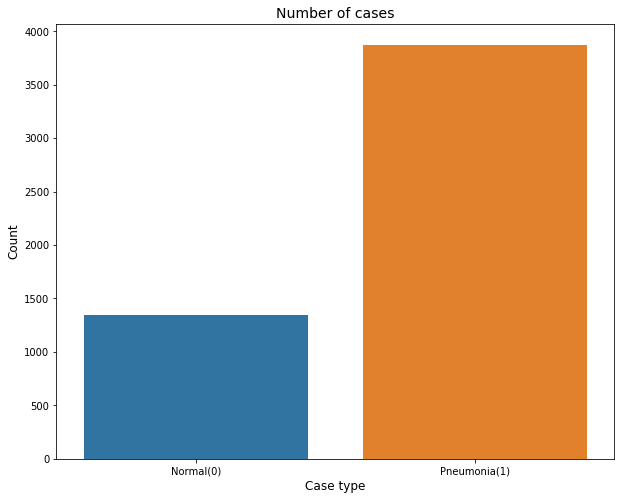

In [121]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

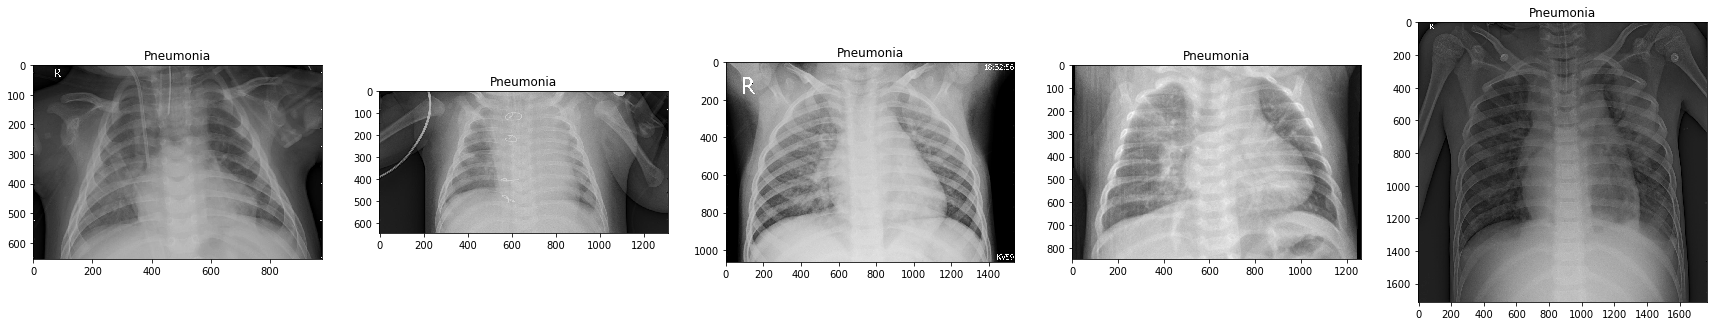

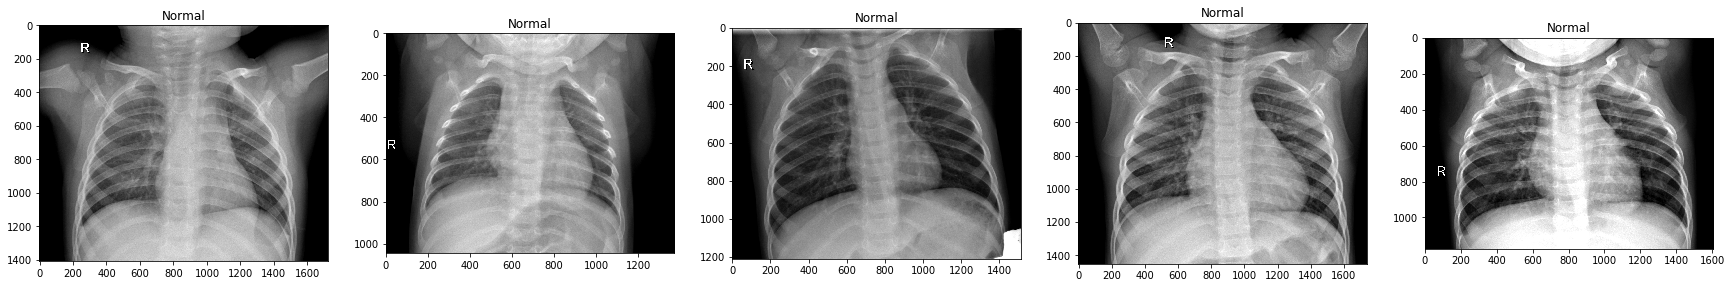

In [122]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()


# Plot the data  
f, ax = plt.subplots(1,5, figsize=(30,30))

for i in range(5):
    img = imread(pneumonia_samples[i])
    ax[i%5].imshow(img, cmap='gray')
    ax[i%5].set_title("Pneumonia")
plt.show()

f, ax = plt.subplots(1,5, figsize=(30,30))

for i in range(5):
    img = imread(normal_samples[i])
    ax[i%5].imshow(img,cmap='gray')
    ax[i%5].set_title("Normal")
plt.show()

In [123]:
image_size = 150
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 6
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator_with_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [124]:
train_generator.image_shape

(150, 150, 3)

In [125]:
import tensorflow as tf
vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = tf.keras.applications.VGG16(
    weights=vgg_weights_path,
    include_top=False,
    input_shape=(150, 150, 3)
)
base_model.trainable = False

In [126]:
def model():
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(units=512, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.7)(model)
    predictions = tf.keras.layers.Dense(units=2, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [127]:
model = model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [128]:
model.fit_generator(
    train_generator,
    epochs=2,
    verbose=1,
    validation_data=validation_generator,
)

Epoch 1/2
326/326 [==============================] - 93s 284ms/step - loss: 0.9208 - acc: 0.8677 - val_loss: 0.2480 - val_acc: 0.9375
Epoch 2/2
326/326 [==============================] - 91s 279ms/step - loss: 0.2485 - acc: 0.9133 - val_loss: 0.4973 - val_acc: 0.8125


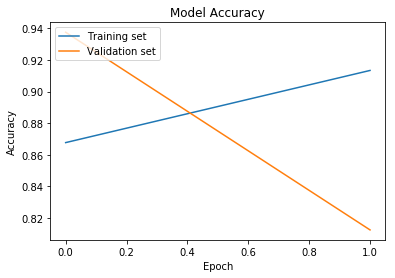

In [129]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [130]:
loss, test_acc = model.evaluate_generator(
    test_generator,
    steps=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    verbose=1
)

print(test_acc)

39/39 [==============================] - 7s 182ms/step - loss: 0.4415 - acc: 0.8397
0.8397436


In [131]:
filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/batch_size))

In [133]:
np.shape(predict)

(624, 2)

In [146]:
predict[0]

array([0.06544672, 0.93455327], dtype=float32)

In [160]:
pred_y=[]
for i in predict:
    if i[0] > i[1]:
        pred_y.append(0)
    else:
        pred_y.append(1)
collections.Counter(pred_y)

Counter({1: 474, 0: 150})

In [144]:
import collections
collections.Counter(test_generator.labels)

Counter({0: 234, 1: 390})

<Figure size 432x288 with 0 Axes>

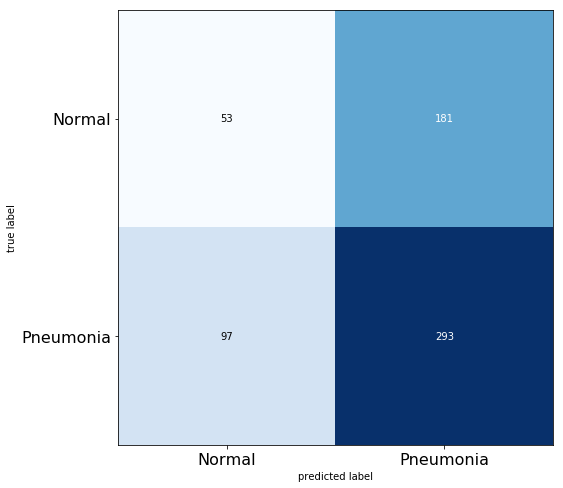

In [161]:
from sklearn.metrics import confusion_matrix,f1_score
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(test_generator.labels, pred_y)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8))
plt.xticks(range(2), ['Normal', 'Pneumonia'])
plt.yticks(range(2), ['Normal', 'Pneumonia'])
plt.show()


In [158]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall :",recall)
print("Precision : ",precision)
print("F1 score : ",f1_score(test_generator.labels,pred_y))

Recall : 0.7512820512820513
Precision :  0.6181434599156118
F1 score :  0.6782407407407408


In [135]:
normal_cases = glob(test_dir+'NORMAL/*.jpeg')
pneumonia_cases = glob(test_dir+'PNEUMONIA/*.jpeg')
print(len(normal_cases),len(pneumonia_cases))

234 390


In [ ]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [ ]:
from pathlib import Path

test_dir = Path('../input/chest_xray/chest_xray/test')

normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

In [ ]:
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150, 150))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

In [ ]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

In [ ]:
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

In [ ]:
num_classes = 2
EPOCHS = 10
STEPS = nb_train_samples / batch_size

In [ ]:
vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16 = VGG16(pooling='avg', 
                  weights=vgg_weights_path,
                  input_shape=(image_size, image_size, 3),
                  include_top = False)

# Freeze all layers in Resnet
for layer in vgg16.layers:
    layer.trainable = False

# Stack the pre-trained model with a fully-connected layer
# Add fully-connect layer (aka Dense layer) with softmax activation
x = vgg16.output
# x = Flatten()(x)
# x = Dense(num_classes, activation='softmax')(x)

# FC layer
x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
# x = Dropout(rate=0.3)(x)
# x = Dense(units=4096, activation='relu')(x)
# x = Dropout(rate=0.3)(x)
x = Dense(units=2, activation='softmax')(x)



# Define loss function, optimizer and metrics
model = Model(inputs=vgg16.input, outputs= x)

optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_acc", mode="max", verbose = 2)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit_generator(
    train_generator, # specify where model gets training data
    epochs = EPOCHS,
    steps_per_epoch=STEPS,
    validation_data=validation_generator, # specify where model gets validation data
    callbacks=[early_stopping_monitor])

# history = model.fit_generator(epochs=5, callbacks=[early_stopping_monitor], shuffle=True, validation_data=val_batches, generator=train_batches, steps_per_epoch=500, validation_steps=10,verbose=2)

# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# # Load the pre-trained model
# vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#
 #model = Sequential()
 #model.add(VGG16(include_top=False, pooling='avg', weights=vgg_weights_path))
 #model.add(Dense(units=2, activation='softmax'))
 #model.layers[0].trainable = False

 #model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.summary()

In [ ]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [ ]:
# Loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()